基于深度学习的文本分类,Kaggle代码[LSTM 实现](https://www.kaggle.com/code/hanjoonchoe/movie-sentimental-analysis-lstm-pytorch)详解。

In [ ]:
import numpy as np 
import pandas as pd 
import torch
import random
import pickle
from tqdm import tqdm
from collections import Counter
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F

In [2]:
train = pd.read_csv('./data/train.tsv',sep='\t')
test = pd.read_csv('./data/test.tsv',sep='\t')

In [3]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
def Corpus_Extr(df):
    # 构建语料库
    print('Construct Corpus...')
    corpus = []
    for i in tqdm(range(len(df))):
        corpus.append(df.Phrase[i].lower().split())
    
    # 统计词频
    corpus = Counter(np.hstack(corpus))
    corpus = corpus

    # 排序语料库
    corpus2 = sorted(corpus,key=corpus.get,reverse=True)

    # 将语料库中的单词转换为整数
    print('Convert Corpus to Integers')
    vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}

    # 将短语转换为整数序列
    print('Convert Phrase to Integers')
    phrase_to_int = []
    for i in tqdm(range(len(df))):
        phrase_to_int.append([vocab_to_int[word] for word in df.Phrase.values[i].lower().split()])
    return corpus,vocab_to_int,phrase_to_int

corpus,vocab_to_int,phrase_to_int = Corpus_Extr(train)

Construct Corpus...


100%|██████████| 156060/156060 [00:01<00:00, 106095.64it/s]


Convert Corpus to Integers
Convert Phrase to Integers


100%|██████████| 156060/156060 [00:01<00:00, 128755.83it/s]


#### 代码详解

**整体解释：**

这段代码定义了一个名为`Corpus_Extr`的函数，用于从数据框`df`中构建语料库，并将语料库中的单词及短语转换为整数表示。下面是对函数中各步骤的详细解释：

1. **构建语料库：**
   - 首先打印出`'Construct Corpus...'`提示开始构建语料库。
   - 通过迭代数据框`df`中的每一行来构建一个单词列表`corpus`。对于`df`中的每个"Phrase"项，都将其转换为小写并分割成单词，然后加入到`corpus`列表中。

2. **统计词频：**
   - 使用`np.hstack`将`corpus`中的所有单词列表连接成一个大的一维数组。
   - 使用`Counter`统计这个数组中每个单词的出现次数，即得到一个词频字典`corpus`。

3. **排序语料库：**
   - 使用`sorted`函数对`corpus`按词频降序排序，生成新的列表`corpus2`。

4. **将语料库中的单词转换为整数：**
   - 打印出`'Convert Corpus to Integers'`提示开始转换。
   - 通过`enumerate`函数为排序后的语料库`corpus2`中的每个单词分配一个独一无二的索引（整数类型），从1开始编号（因为1作为参数传递给了`enumerate`），创建一个`vocab_to_int`字典。 例如，`A`的索引为`3`，对应的编号为`3`，,`series`的索引为`315`，则编号为`315`。

5. **将短语转换为整数序列：**
   - 打印出`'Convert Phrase to Integers'`提示开始转换。
   - 再次迭代数据框`df`的每一行，并使用`vocab_to_int`字典将每个短语中的单词转换为其对应的整数（索引），生成`phrase_to_int`列表。这个列表包含了转换为整数序列的短语。例如，短语为`A series` ，则转换为`[3, 315]`

6. **返回结果：**
   - 函数返回三个对象：`corpus`（词频字典），`vocab_to_int`（单词到整数的字典），和`phrase_to_int`（短语到整数序列的列表）。

在函数调用的最后一行，`Corpus_Extr`函数被用于数据框`train`，并且将返回的对象赋值给变量`corpus`，`vocab_to_int`，和`phrase_to_int`。



**细节解释：**

1. `corpus = Counter(np.hstack(corpus))`

`np.hstack()`函数用于将两个或多个数组连接成一个数组，这里将`corpus`列表中的所有单词连接成一个数组，然后使用`Counter()`函数计算每个单词的计数。

`Counter()`函数用于计算序列中元素的频率。它接受一个可迭代对象（如列表、元组等）作为参数，并返回一个字典，其中键是序列中的元素，值是对应的元素出现的次数。

例如，如果`corpus`列表中包含以下单词：
```
['apple', 'banana', 'apple', 'orange', 'banana', 'apple']
```
则`corpus`列表中的单词计数将如下所示：
```
Counter({'apple': 3, 'banana': 2, 'orange': 1})
```
其中，`'apple'`出现了3次，`'banana'`和`'orange'`各出现了2次。

-----

2. `vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}`

创建了一个字典vocab_to_int，用于将corpus2中的单词映射到整数索引。

  -  `{}`：这是字典的创建方法，表示创建一个空字典。

  -  `word: idx`：这是字典的键值对，其中word是键，idx是值。

  -  `for idx, word in enumerate(corpus2, 1)`：这是一个for循环，用于迭代corpus2中的元素。enumerate函数将corpus2中的每个元素与它的索引配对。idx是索引，word是corpus2中的元素。

  -  `enumerate(corpus2, 1)`：enumerate函数用于返回一个枚举对象，它生成一个包含索引和值的元组。参数1指定开始索引的值，这里设置为1。

  -  `word: idx for idx, word in enumerate(corpus2, 1)`：这是一个字典推导式，它使用enumerate函数生成的元组创建字典的键值对。

代码行`vocab_to_int = {word: idx for idx,word in enumerate(corpus2,1)}`将corpus2中的单词作为键，索引作为值，创建了一个映射字典vocab_to_int。索引的起始值为1。 这个字典可以在后续代码中用来将单词转换为整数索引。

In [6]:
# 填充序列
def Pad_sequences(phrase_to_int,seq_length):
    # 初始化填充序列的矩阵
    pad_sequences = np.zeros((len(phrase_to_int), seq_length),dtype=int)
    # 填充或截断序列
    for idx,row in tqdm(enumerate(phrase_to_int),total=len(phrase_to_int)):
        pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]
    return pad_sequences

#### 代码解释

**整体解释：**

这段代码定义了一个名为`Pad_sequences`的函数，其功能是将整数序列列表`phrase_to_int`填充（或截断）到一个统一的长度`seq_length`。让我们逐步了解这个函数的工作流程：

1. **初始化填充序列的矩阵：**
   - 创建一个名为`pad_sequences`的矩阵，其形状为`(len(phrase_to_int), seq_length)`，即行数等于整数序列列表中短语的数量，列数等于指定的序列长度`seq_length`。
   - 该矩阵被初始化为零，并且数据类型设为整数。

2. **填充或截断序列：**
   - 通过迭代`phrase_to_int`中的每个整数序列，`enumerate`函数提供当前序列的索引`idx`和序列的内容`row`。
   - `tqdm`被用于包装迭代器，显示进度条，`total`参数设定为`phrase_to_int`的长度，确保进度条反映整体进度。
   - 对于每一行，将行索引`idx`对应的`pad_sequences`的前n个元素设置为`row`的内容，其中n是`row`的长度或`seq_length`中较小的一个，这保证了不会超过指定的序列长度。
   - 如果`row`的长度小于`seq_length`，则保持剩余元素为0（即填充）；如果`row`的长度大于`seq_length`，则`row`将被截断到`seq_length`。

3. **返回填充后的矩阵：**
   - 函数最终返回`pad_sequences`矩阵，其包含了填充（或截断）后的整数序列。

例如，如果我们有以下整数序列列表`[[1, 2, 3], [4, 5]]`和序列长度`seq_length = 5`，使用`Pad_sequences`函数后，我们会得到一个矩阵：

```
[
 [1, 2, 3, 0, 0],
 [4, 5, 0, 0, 0]
]
```

填充技术常用于自然语言处理中，尤其是在准备训练模型的数据时，因为模型通常需要固定长度的输入序列。填充是增加额外的“无意义”数据来达到这个长度，而截断是丢弲末尾的数据以缩短序列长度。

**细节解释：**

- `pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]`

这行代码是`Pad_sequences`函数中用来对单个短语的整数序列进行填充或截断的关键操作。让我们分解这个操作：

1. `pad_sequences[idx, :len(row)]`:
   - `pad_sequences`是一个二维numpy数组，其大小为`(len(phrase_to_int), seq_length)`，其中`len(phrase_to_int)`是短语的总数，`seq_length`是填充后序列的固定长度。
   - `idx`是当前正在处理的短语的索引。
   - `:len(row)`是一个切片操作，用来指定`pad_sequences`的第`idx`行的从第一个元素到`len(row)`个元素。这意味着只有当前短语长度内的部分将被新值替换，超出当前短语长度的部分（即填充部分）仍然保持初始化时的零值。
   - 当`len(row)` < = `seq_length`时，`pad_sequences[idx, :len(row)]`表示`pad_sequences`前`len(row)`个值替换为`row`(短语的整数序列)。
   - 当`len(row)` > `seq_length`时，`pad_sequences`只能切片到`seq_length`的长度，即`pad_sequences`前`seq_length`个值替换为`row`(短语的整数序列)的前`seq_length`个值。
   
2. `np.array(row)[:seq_length]`:
   - `row`表示当前短语的整数序列。
   - `np.array(row)`将这个列表转换为numpy数组，以使用numpy的切片功能。
   - `[:seq_length]`是一个切片操作，用来选取从开头到`seq_length`位置的元素。这里的作用是确保即使`row`的长度大于`seq_length`，也只选取前`seq_length`个元素进行操作。

综合来看，`pad_sequences[idx, :len(row)] = np.array(row)[:seq_length]`这行代码的作用是：
   - 如果当前整数序列`row`的长度小于或等于`seq_length`，那么`row`中的全部元素将被复制到`pad_sequences`的第`idx`行，且不会有任何改变（`row`长度小于`seq_length`时，剩余部分保持为零）。
   - 如果当前整数序列`row`的长度大于`seq_length`，那么`row`将被截断，只有前`seq_length`个元素被复制到`pad_sequences`的第`idx`行。

这种操作允许在不改变原有语料顺序的基础上，统一短语的长度，以便它们能被用于需要固定大小输入的机器学习模型中。


In [7]:
pad_sequences = Pad_sequences(phrase_to_int,30)

100%|██████████| 156060/156060 [00:00<00:00, 586561.27it/s]


In [8]:
train.sample(50)

,PhraseId,SentenceId,Phrase,Sentiment
146370,146371,7961,Ever see one of those comedies that just seem ...,1
109634,109635,5809,"The slapstick is labored , and the bigger setp...",0
38716,38717,1845,this turd,0
155765,155766,8526,The Santa Clause 2 is a barely adequate babysi...,1
35762,35763,1687,be able to look away for a second,3
154282,154283,8431,been lost in the translation this time,1
28948,28949,1341,"is very , very far",1
18779,18780,825,averting,2
75864,75865,3891,I could not stand them,0
14023,14024,603,playful respite,3


In [9]:
class PhraseDataset(Dataset):
    def __init__(self,df,pad_sequences):
        super().__init__()
        self.df = df
        self.pad_sequences = pad_sequences
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        if 'Sentiment' in self.df.columns:
            label = self.df['Sentiment'].values[idx]
            item = self.pad_sequences[idx]
            return item,label
        else:
            item = self.pad_sequences[idx]
            return item

In [10]:
class SentimentRNN(nn.Module):
    
    def __init__(self,corpus_size,output_size,embedd_dim,hidden_dim,n_layers):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(corpus_size,embedd_dim)
        self.lstm = nn.LSTM(embedd_dim, hidden_dim,n_layers,dropout=0.5, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim,output_size)
        self.act = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds,hidden)
        lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.act(out)
        out = out.view(batch_size,-1)
        out = out[:,-5:]
        return out, hidden
    def init_hidden(self,batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

#### 代码解释
这段代码定义了一个名为`SentimentRNN`的类，它是一个继承自`nn.Module`的PyTorch神经网络模型，用于情感分析。下面是详细解释每个部分：

**类初始化方法 (`__init__`):**

- `self.output_size`: 输出层的大小。
- `self.n_layers`: LSTM层的数量。
- `self.hidden_dim`: LSTM层中隐藏状态的特征维度。
- `self.embedding`: 嵌入层，使用`nn.Embedding`根据语料库大小和词嵌入维度`embedd_dim`创建了一个查找表，用于将单词整数映射转成嵌入向量。
- `self.lstm`: LSTM层，定义了LSTM网络的结构，包括输入数据的维度`embedd_dim`、隐藏层维度`hidden_dim`、层数`n_layers`、以及dropout比率为0.5，`batch_first=True`指明输入数据的第一个维度是批次大小。
- `self.dropout`: 丢弃层，使用`nn.Dropout`定义丢弃率为0.3以减少过拟合。
- `self.fc`: 全连接层，使用`nn.Linear`将LSTM的输出映射到输出层的大小`output_size`。
- `self.act`: 激活层，使用`nn.Sigmoid`函数，该函数的输出通常用于二分类情感分析（输出一个概率值表示正面情感的概率）。

**前向传播方法 (`forward`):**

- `batch_size`: 通过获取输入`x`的第一个维度大小来确定批次大小。
- `embeds`: 使用嵌入层将输入的单词整数序列转换为嵌入向量。
- `lstm_out`, `hidden`: LSTM层的输出和隐藏状态。
- `lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)`: 调整LSTM层输出的形状以匹配全连接层的输入要求。
- `self.dropout(lstm_out)`: 应用丢弃层。
- `self.fc(out)`: 将丢弃层的输出通过全连接层。
- `self.act(out)`: 使用Sigmoid激活函数。

接着将处理过的输出调整回批次格式，并通过`out[:,-5:]`得到每个序列的最后五个时间步（短语）的结果。这假定情感的输出可能取决于序列的最后几个单词。

**初始化隐藏状态方法 (`init_hidden`):**

- 用于初始化一个包含两个全零张量的隐藏状态元组。(一个用于LSTM的隐藏状态，另一个用于LSTM的细胞状态)。
- `batch_size`: 批次大小，决定了隐藏状态的第二维的大小。
- `weight.new`: 创建一个与模型参数同类型的张量，`self.parameters()`是一个迭代器，包含模型所有参数。
- `zero_()`: 将张量内的所有元素置为0。

总体来说，这个`SentimentRNN`是一个用于情感分析的循环神经网络，它会输出每个输入序列的情感倾向，这是通过查看序列最后五个元素的输出来判断的。这个网络在初始化时需要定义一系列的参数，并在之后可以接收输入数据和相应的隐藏状态进行前向传播以及在训练前初始化隐藏状态。

In [11]:
vocab_size = len(vocab_to_int) # 语料库大小
output_size = 5 # 输出维度
embedding_dim = 400 # 词嵌入维度
hidden_dim = 256 # 隐藏层维度
n_layers = 2 # 隐藏层数
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim,n_layers)

In [12]:
print(net)

SentimentRNN(
  (embedding): Embedding(16531, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (act): Sigmoid()
)


In [14]:
import gc

In [16]:
net.train()
clip=5
epochs = 200
counter = 0
print_every = 20
lr=0.01

def criterion(input, target, size_average=True):
    """Categorical cross-entropy with logits input and one-hot target"""
    l = -(target * torch.log(F.softmax(input, dim=1) + 1e-10)).sum(1)
    if size_average:
        l = l.mean()
    else:
        l = l.sum()
    return l
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

batch_size=32
losses = []
accs=[]
for e in range(epochs):
    a = np.random.choice(len(train)-1, 1000)
    train_set = PhraseDataset(train.loc[train.index.isin(np.sort(a))],pad_sequences[a])
    train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
    # initialize hidden state
    h = net.init_hidden(32)
    running_loss = 0.0
    running_acc = 0.0
    # batch loop
    for idx,(inputs, labels) in enumerate(train_loader):
        counter += 1
        gc.collect()
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        optimizer.zero_grad()
        if inputs.shape[0] != batch_size:
            break
        # get the output from the model
        output, h = net(inputs, h)
        labels=torch.nn.functional.one_hot(labels, num_classes=5)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.cpu().detach().numpy()
        running_acc += (output.argmax(dim=1) == labels.argmax(dim=1)).float().mean()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        if idx%print_every == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format((running_loss/(idx+1))))
            losses.append(float(running_loss/(idx+1)))
            print(f'acc:{running_acc/(idx+1)}')
            accs.append(running_acc/(idx+1))

Epoch: 1/200... Step: 1... Loss: 1.412927...
acc:0.46875
Epoch: 1/200... Step: 11... Loss: 1.417399...
acc:0.47159090638160706
Epoch: 1/200... Step: 21... Loss: 1.408894...
acc:0.480654776096344
Epoch: 1/200... Step: 31... Loss: 1.404616...
acc:0.4868951737880707
Epoch: 2/200... Step: 33... Loss: 1.388400...
acc:0.5
Epoch: 2/200... Step: 43... Loss: 1.389541...
acc:0.5
Epoch: 2/200... Step: 53... Loss: 1.389531...
acc:0.5104166865348816


KeyboardInterrupt: 

#### 代码解释
这段代码是一个典型的深度学习训练循环，用于训练一个名为`net`的神经网络。代码的主要组成部分是设置训练参数、定义损失函数、配置优化器以及执行训练循环。这里是每个部分的详细解释：

1. **初始化训练参数：**
   - `net.train()`：确保处于训练模式，特别是对于包含dropout或批归一化层的网络。
   - `clip=5`：设置梯度裁剪的最大阈值，防止梯度爆炸问题。
   - `epochs = 200`：将网络训练200个时代（epochs）。
   - `counter = 0`：用以计数训练步骤总数。
   - `print_every = 100`：每训练100个batch，打印一次训练信息。
   - `lr=0.01`：设置优化器的学习率为0.01。

2. **定义自定义损失函数：**

   在上述代码中，自定义的损失函数`criterion`用于计算分类任务中的交叉熵损失。这个函数接受两个参数：`input`和`target`，以及一个可选的参数`size_average`，详细解释如下：

   （1） 参数：
      - `input`：模型的原始输出（logits），在多分类问题中通常是一个二维张量，形状为 `(batch_size, num_classes)`，表示批量数据的类别未归一化的预测分数。
      - `target`：实际标签的one-hot表示，形状与`input`相同，每一行对应于一个样本的类别标签的one-hot编码。
      - `size_average`：布尔值，决定最终损失是否要在样本上取平均。默认值`True`表示计算损失的平均值，而`False`表示损失的总和。
      
   （2） 损失计算流程：
      1. `F.softmax(input, dim=1)`: 对`input`应用Softmax函数，以每个样本的预测分数转换成概率分布。Softmax作用在第一个维度上（`dim=1`），即将每一个样本的logits归一化成概率值。
      2. `+ 1e-10`: 在应用对数函数前，加上一个小的常数`1e-10`，防止数值不稳定问题，尤其是防止当概率值为零时对数无法计算的情况。
      3. `torch.log(...)`: 对Softmax的结果取对数。因为交叉熵损失涉及到概率的对数，所以需要这一步。
      4. `-(target * ...)`: 将目标one-hot向量与对数概率相乘。在one-hot编码中，正确标签的位置为1，其余位置为0，因此这一操作将选出每个样本正确类别的对数概率。
      5. `.sum(1)`: 对每个样本的结果按类别求和，由于正确标签的位置为1其他为0，因此每个样本只计算了正确类别的负对数似然。
      6. `if size_average ... else ...`: 根据`size_average`参数的值，决定是计算损失的平均值（`.mean()`）还是总和（`.sum()`）。
      7. `return l`: 返回计算后的损失值。




3. **配置优化器：**
   - `optimizer`：一个使用Adam优化算法和指定学习率来更新`net`参数的优化器。

4. **训练过程：**


- 初始化和构建训练数据：

1. `a = np.random.choice(len(train)-1, 1000)`: 从`train`数据集中随机选择1000个样本（不包括最后一个）。`len(train)-1`确保在选择时不会超出索引范围。

2. `train_set = PhraseDataset(train.loc[train.index.isin(np.sort(a))], pad_sequences[a])`: 使用选中的样本索引来创建`train_set`，一个PyTorch数据集。`PhraseDataset`是一个自定义数据集类，用于存储训练数据和对应的序列化表示（`pad_sequences[a]`）。

3. `train_loader = DataLoader(train_set, batch_size=32, shuffle=True)`: 利用`DataLoader`将`train_set`封装成一个可迭代的数据加载器，每次迭代返回一批数据。参数`batch_size=32`指明每批次包含32个样本，`shuffle=True`表示在每个epoch开始时，数据将被打乱。

- 训练循环：

对于每一个epoch（一个epoch表示遍历一次完整的数据集）：

4. `h = net.init_hidden(32)`: 初始化网络的隐藏状态。这对于训练RNNs（递归神经网络）或LSTMs（长短期记忆网络）是必要的。

5. `running_loss = 0.0` 和 `running_acc = 0.0`: 初始化变量用于累计一个epoch中所有批次的损失和准确率。

接下来，对于每一个批次：

6. `gc.collect()`: Python的垃圾收集器，用来尝试释放内存中未使用的对象。

每个batch循环开始：

7. `h = tuple([each.data for each in h])`: 分离隐藏状态，以免在整个训练历史中进行反向传播。

8. `optimizer.zero_grad()`: 清零之前的梯度，否则梯度将会累加到已有的梯度上。

9. `if inputs.shape[0] != batch_size: break`: 如果当前批次的大小不等于预设的batch_size，则跳过该批次。

10. `output, h = net(inputs, h)`: 通过模型进行前向传播，得到预测输出和新的隐藏状态。

11. `labels = torch.nn.functional.one_hot(labels, num_classes=5)`: 将标签转换为one-hot编码，总共有5个类别。

12. `loss = criterion(output, labels)`: 计算模型输出和实际标签之间的损失。

13. `loss.backward()`: 进行反向传播，计算损失对模型参数的梯度。

14. `running_loss += loss.cpu().detach().numpy()`: 将当前batch的损失累加到总损失上。

15. `running_acc += (output.argmax(dim=1) == labels.argmax(dim=1)).float().mean()`: 计算并累加当前batch的准确率。

16. `nn.utils.clip_grad_norm_(net.parameters(), clip)`: 对梯度进行裁剪，以防止梯度爆炸。

17. `optimizer.step()`: 更新网络参数。

- 打印和记录训练进度：

18. `if idx % print_every == 0`: 满足条件时，即经过`print_every`设置的数目的批次后，打印当前训练的状态。

19. 打印包含当前epoch、步数、损失的字符串。

20. `losses.append(float(running_loss/(idx+1)))` 和 `accs.append(running_acc/(idx+1))`: 将平均损失和平均准确率记录到列表中，用于之后分析模型训练过程的性能。


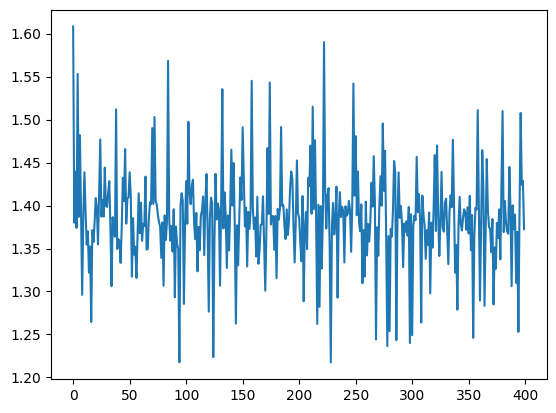

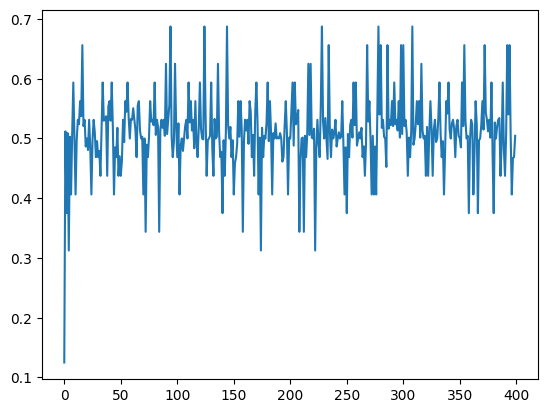

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
plt.plot(accs)
plt.show()